## Realistic distance measure using door information

In [2]:
import geopandas as gpd
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import os

import warnings
warnings.filterwarnings('ignore')

In [3]:
# read room polygons from esri gdb
gdb_path = os.path.expanduser('~/work/test-data/test.gdb')
rooms = gpd.read_file(gdb_path, layer=2)  # room polygon is the second layer in our gdb
doors = gpd.read_file(gdb_path, layer=1)  # door polygon is the first layer in our gdb


Let's find which rooms are connected by each door. We will find two rooms within a certain raidus from a door. We need to handle exceptional cases like these. 

* less than two rooms are found
* more than rwo rooms are found
* multiple doors are connecting two rooms 

In [4]:
def find_rooms(door_center, rooms, radius):
    connected_rooms = list()
    door_buff = door_center.buffer(radius)
    for index, room in rooms.iterrows():
        if room.geometry.intersects(door_buff):
            connected_rooms.append(index)
    return connected_rooms

door_connected = doors.geometry.apply(find_rooms, args=(rooms, 0.02))

In [5]:
print(door_connected.head())

0    [12, 15]
1    [12, 15]
2    [12, 15]
3        [12]
4        [12]
Name: geometry, dtype: object


In [6]:
# create door nodes
node_door = gpd.GeoDataFrame(geometry=doors.geometry.centroid)
node_door["node_type"] = 'door'
node_door["sid"] = "d" + pd.Series(doors.index).apply(str) 
node_door = node_door.set_index("sid")
print(node_door.head())

                                        geometry node_type
sid                                                       
d0   POINT (13293943.69586614 282517.7911198586)      door
d1    POINT (13293937.49868767 282517.690726161)      door
d2    POINT (13293931.30172791 282517.590441823)      door
d3   POINT (13293931.49464129 282508.7638888906)      door
d4   POINT (13293937.61876641 282508.8629702528)      door


In [8]:
# create room nodes
node_room = gpd.GeoDataFrame(geometry=rooms.geometry.centroid)
node_room["node_type"] = 'room'
node_room["sid"] = "r" + pd.Series(rooms.index).apply(str) 
node_room = node_room.set_index("sid")

In [9]:
# merge door and room nodes
nodes = node_door.append(node_room)
print(nodes.head())

                                        geometry node_type
sid                                                       
d0   POINT (13293943.69586614 282517.7911198586)      door
d1    POINT (13293937.49868767 282517.690726161)      door
d2    POINT (13293931.30172791 282517.590441823)      door
d3   POINT (13293931.49464129 282508.7638888906)      door
d4   POINT (13293937.61876641 282508.8629702528)      door


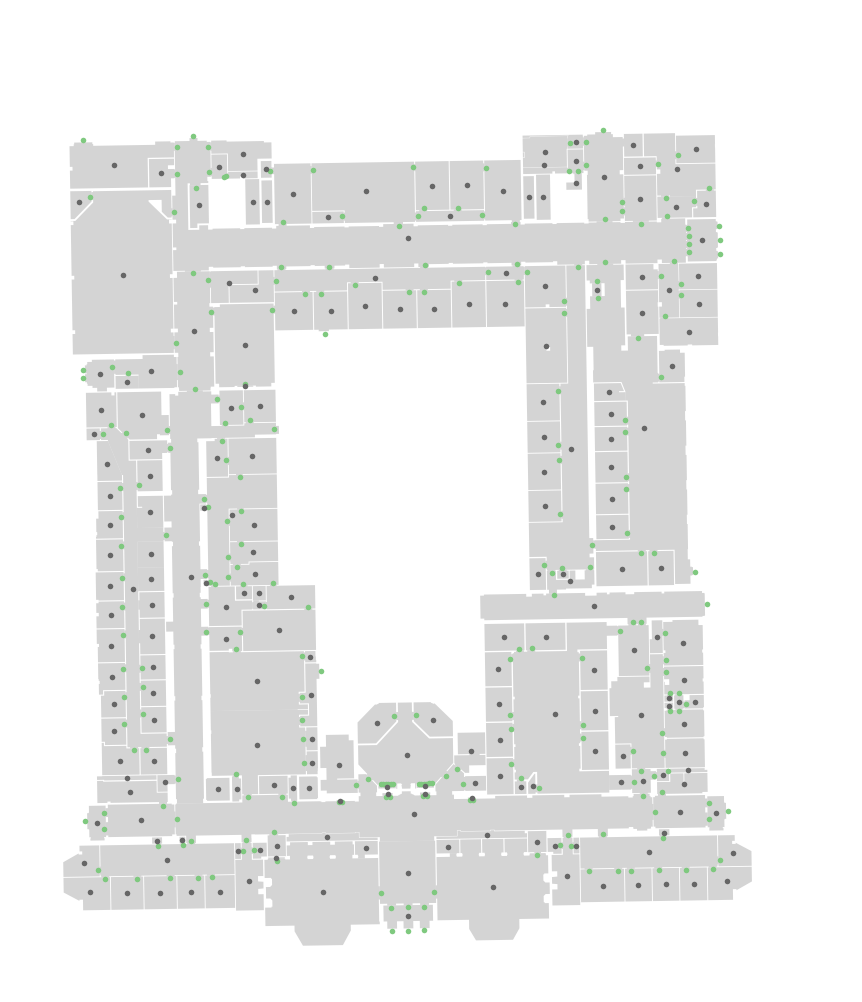

In [10]:
# plot color of doors with number of connected rooms
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.0, color='#aaaaaa')
nodes.plot(ax=ax, markersize=4, markeredgecolor='none', column="node_type", cmap="Accent")
ax.set_aspect('equal')
plt.show()

In [11]:
# let's make door-room connections

lines = {'geometry':[], 'from':[], 'to':[]}

for index, conn in enumerate(door_connected):
    for room in conn:
        did = "d" + str(index)
        rid = "r"  + str(room)
        door = nodes.loc[did]
        room = nodes.loc[rid]
        lines["from"].append(did)
        lines["to"].append(rid)
        lines["geometry"].append(LineString([door.geometry, room.geometry]))
        
# geodataframe for edges
edges = gpd.GeoDataFrame(lines)

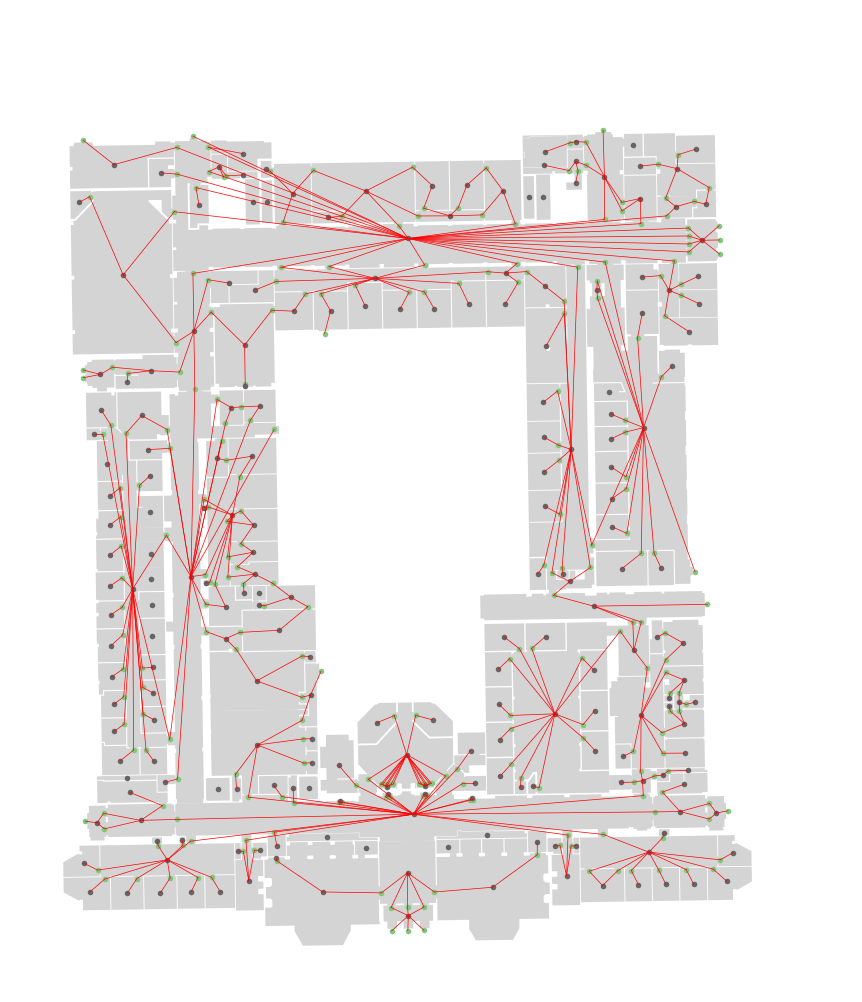

In [12]:
# plot door-room connections
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.0, color='#aaaaaa')
nodes.plot(ax=ax, markersize=4, markeredgecolor='none', column="node_type", cmap="Accent")
edges.plot(ax=ax, linewidth=0.5, color='r')
ax.set_aspect('equal')
plt.show()

In [14]:
# create room-to-room connection 
# if the distance between the two room < threshold
# if the two rooms are not connected by a door

def is_door_connected(rid1, rid2, room_connection):
    connected = False
    for conn in room_connection:
        if set([rid1, rid2]) == set(conn):
            connected = True
            return connected
    return connected
    

threshold = 0.02

# dictionary for edge geometry
room_adj = {'geometry':[], 'from':[], 'to':[]}

for index1, r1 in rooms.iterrows():
    for index2, r2 in rooms.iterrows():
        if r1.geometry.buffer(threshold).intersects(r2.geometry.buffer(threshold)) \
            and index1 > index2 \
            and not is_door_connected(index1, index2, door_connected):
            room_adj["from"].append("r" + str(index1))
            room_adj["to"].append("r" + str(index2))
            room_adj["geometry"].append(LineString([r1.geometry.centroid, r2.geometry.centroid]))

# geodataframe for edges
direct_connection = gpd.GeoDataFrame(room_adj)

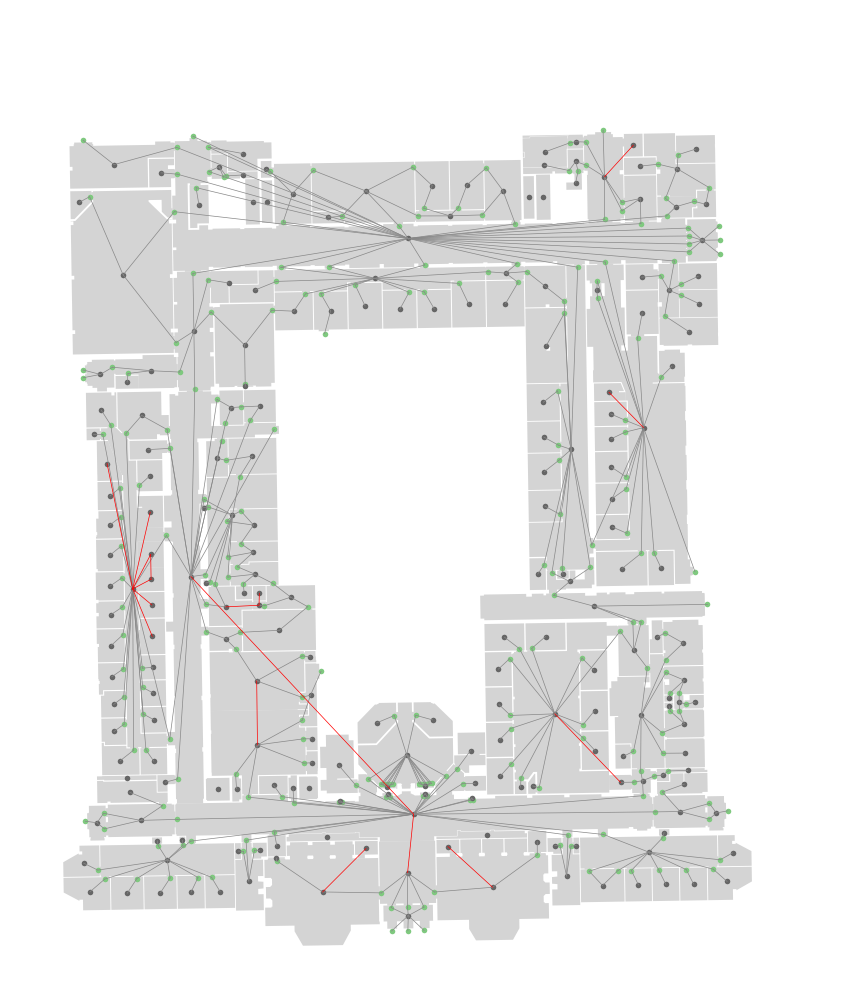

In [15]:
# plot direct connections
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.0, color='#aaaaaa')
nodes.plot(ax=ax, markersize=4, markeredgecolor='none', column="node_type", cmap="Accent")
edges.plot(ax=ax, linewidth=0.5, color='#888888')
direct_connection.plot(ax=ax, linewidth=0.5, color='r')
ax.set_aspect('equal')
plt.show()

In [16]:
#looks good. let's append the direct connections to edges
edges = edges.append(direct_connection)

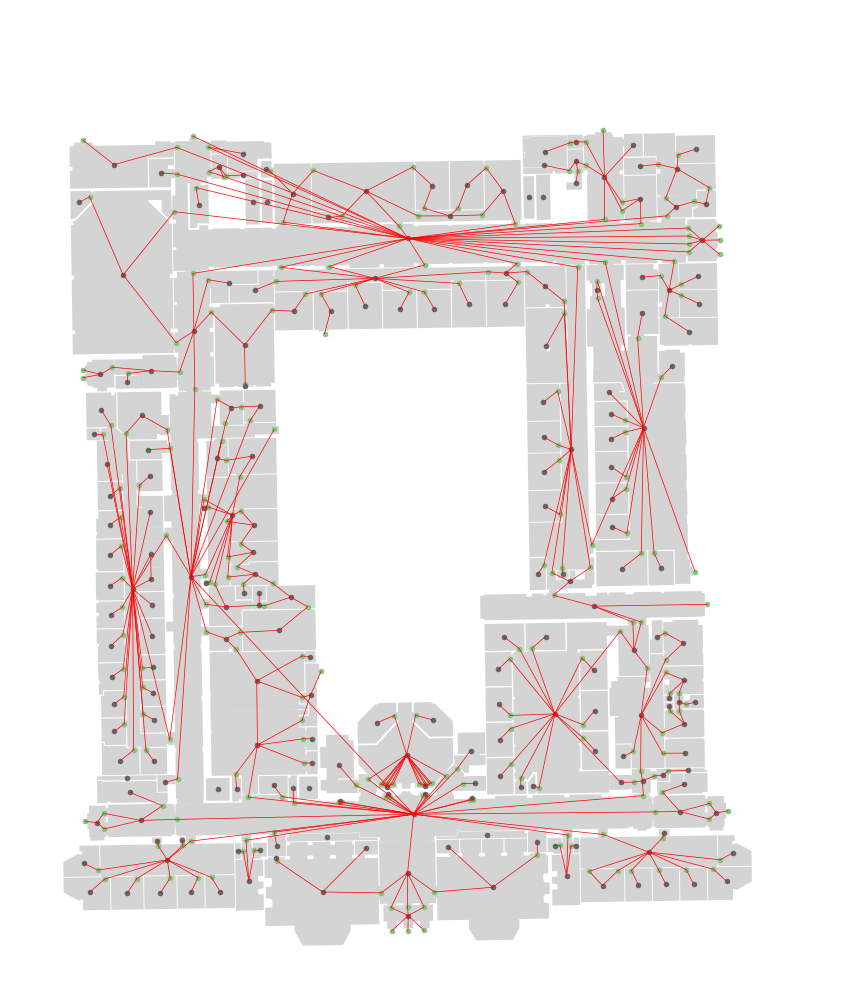

In [17]:
# plot all connections
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.0, color='#aaaaaa')
nodes.plot(ax=ax, markersize=4, markeredgecolor='none', column="node_type", cmap="Accent")
edges.plot(ax=ax, linewidth=0.5, color='red')
ax.set_aspect('equal')
plt.show()

Several edges are too much unrealistic since some of the room polygons are L-shaped such as 164. Or some of the long corridors are connected in L-shape such as 183 and 184. We are going to fix it by dividing these corridors into several pieces.

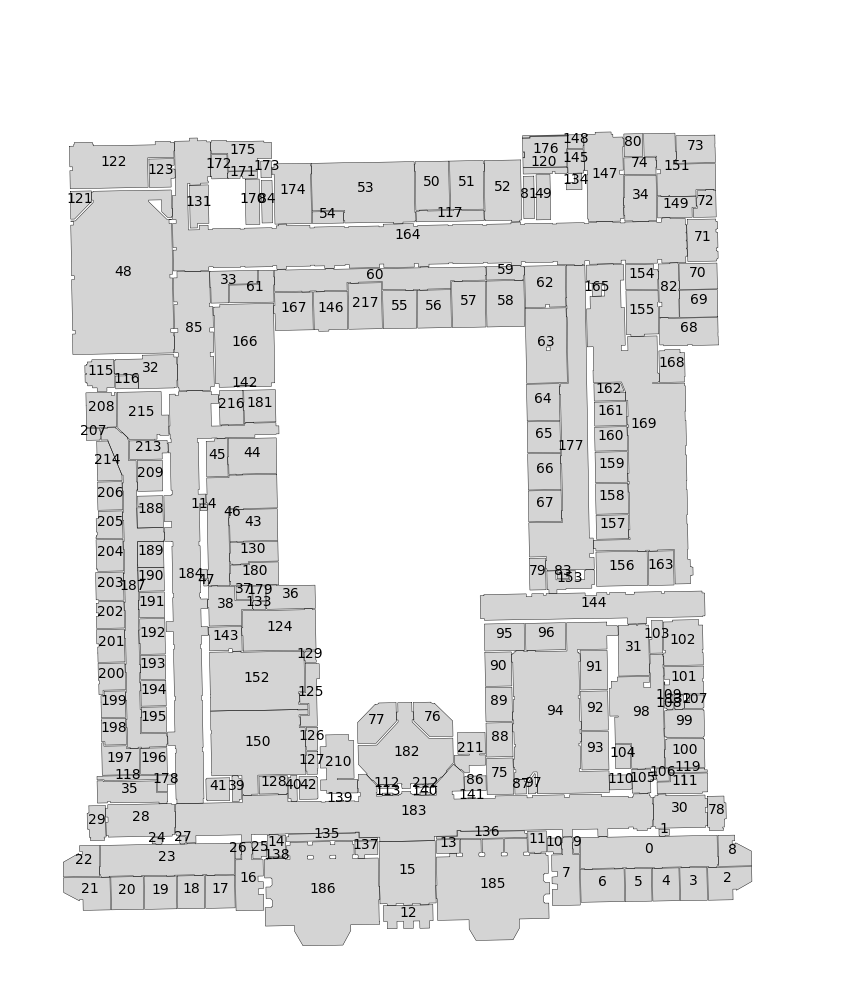

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax.axison = False
rooms.plot(ax=ax, linewidth=0.3, color='#aaaaaa')
ax.set_aspect('equal')

for idx, row in rooms.iterrows():
    plt.annotate(s=idx, xy=[row.geometry.centroid.x, row.geometry.centroid.y],
                 horizontalalignment='center')
    
plt.show()

Let's look at 164. We'd like to divide it into smaller pieces. I don't want to do it with mouse... So, let's label the vertices to call them. 

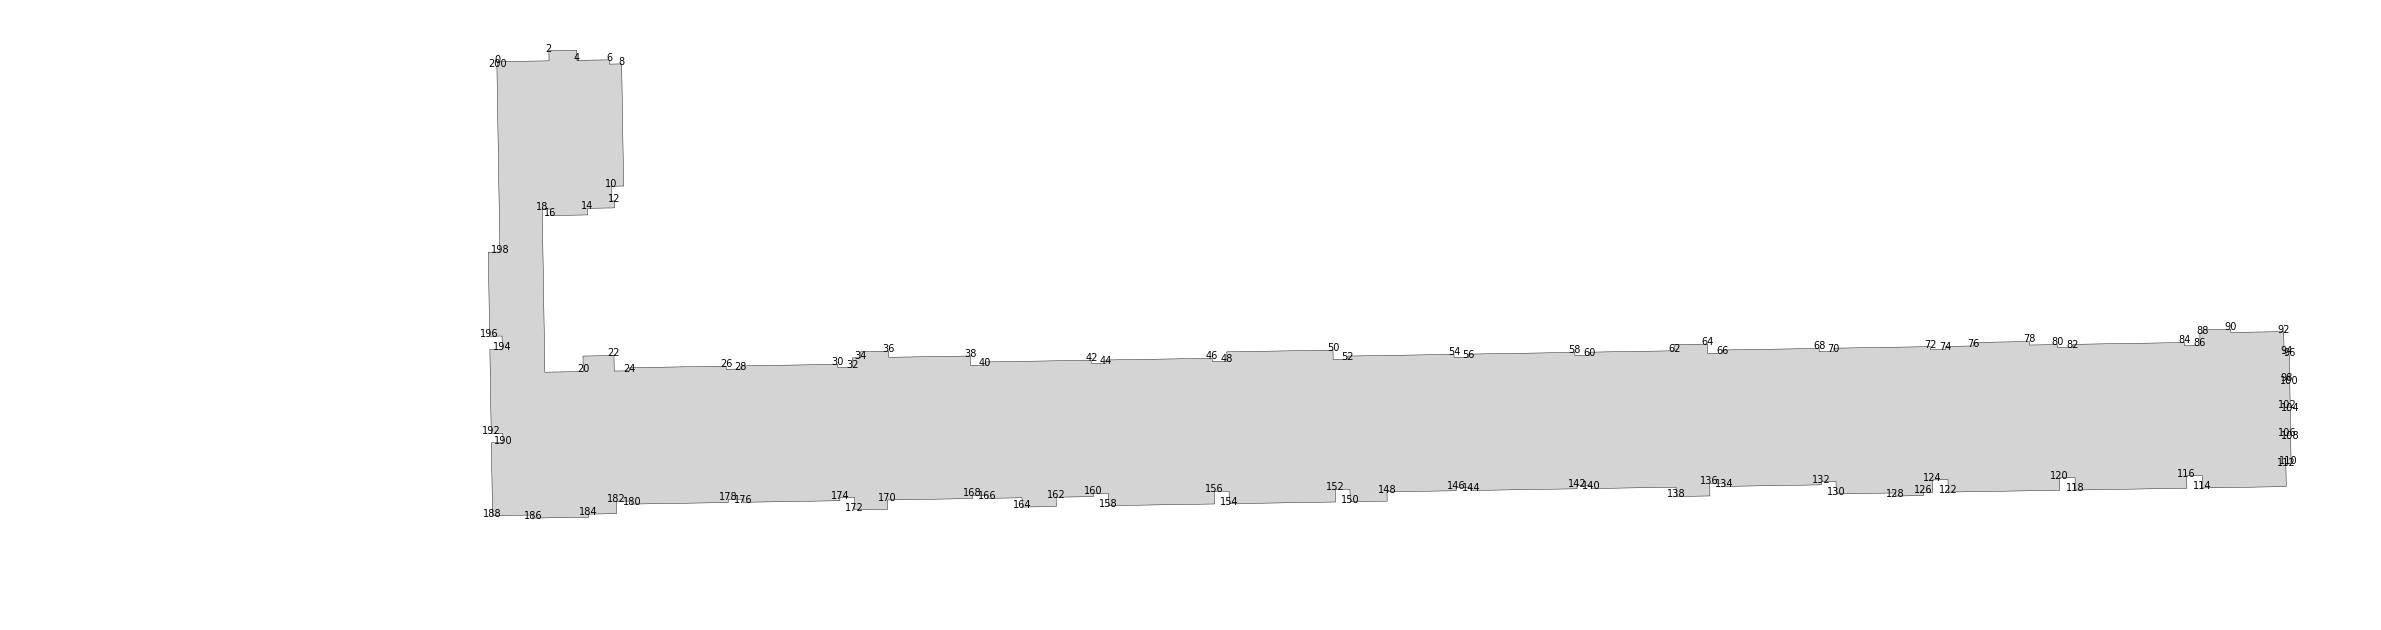

In [20]:
def display_1_polygon(df, rid):
    room = rooms.loc[rid]
    rpoly = room.geometry
    rbound = rpoly[0].boundary.coords

    fig, ax = plt.subplots()
    fig.set_size_inches(30, 30)
    ax.axison = False
    rooms[rooms.index == rid].plot(ax=ax, linewidth=0.3, color='#aaaaaa')
    ax.set_aspect('equal')
    for idx, row in enumerate(rbound):
        if idx%2 == 0: # display every other vertex to prevent overlap
            plt.annotate(s=idx, xy=row, horizontalalignment='center', fontsize=7)
    plt.show()

display_1_polygon(rooms, 164)

In [21]:
## By looking at the polygon, I'd like cut the polygon with line 18-198, 19-194, 20-184, 83-119  
from shapely.geometry import MultiLineString
import shapely

rid = 164
cut_points = [(18,198), (19,194), (20,184), (83,119)]

def cut_polygon_with_line(df, rid, cut_points):
    room = df.loc[rid]
    rpoly = room.geometry
    rbound = rpoly[0].boundary.coords

    lines = [LineString([rbound[p[0]], rbound[p[1]]]) for p in cut_points]
    ml = MultiLineString(lines)

    new_polys = list(shapely.ops.polygonize(rpoly.boundary.union(ml)))
    new_rooms = gpd.GeoDataFrame(data=None, geometry = new_polys)
    for col in df.columns:
        if col == 'geometry':
            pass
        else:
            new_rooms[col] = room[col]
            
    new_df = df.drop(df.index[rid])
    new_df = new_df.append(new_rooms)
    return new_df

nr = cut_polygon_with_line(rooms, 164, cut_points)

Let's chect the new rooms

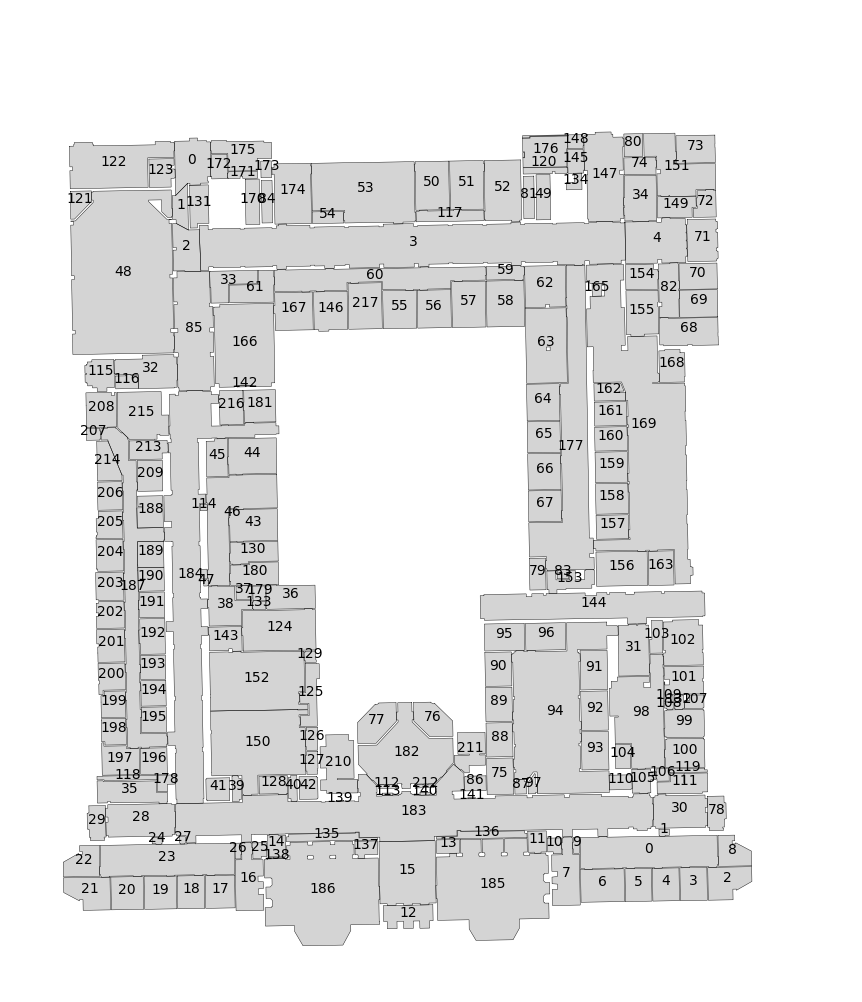

In [22]:
def show_rooms(df):
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 12)
    ax.axison = False
    df.plot(ax=ax, linewidth=0.3, color='#aaaaaa')
    ax.set_aspect('equal')

    for idx, row in df.iterrows():
        plt.annotate(s=idx, xy=[row.geometry.centroid.x, row.geometry.centroid.y],
                     horizontalalignment='center')

    plt.show()

show_rooms(nr)

Let's cut 184

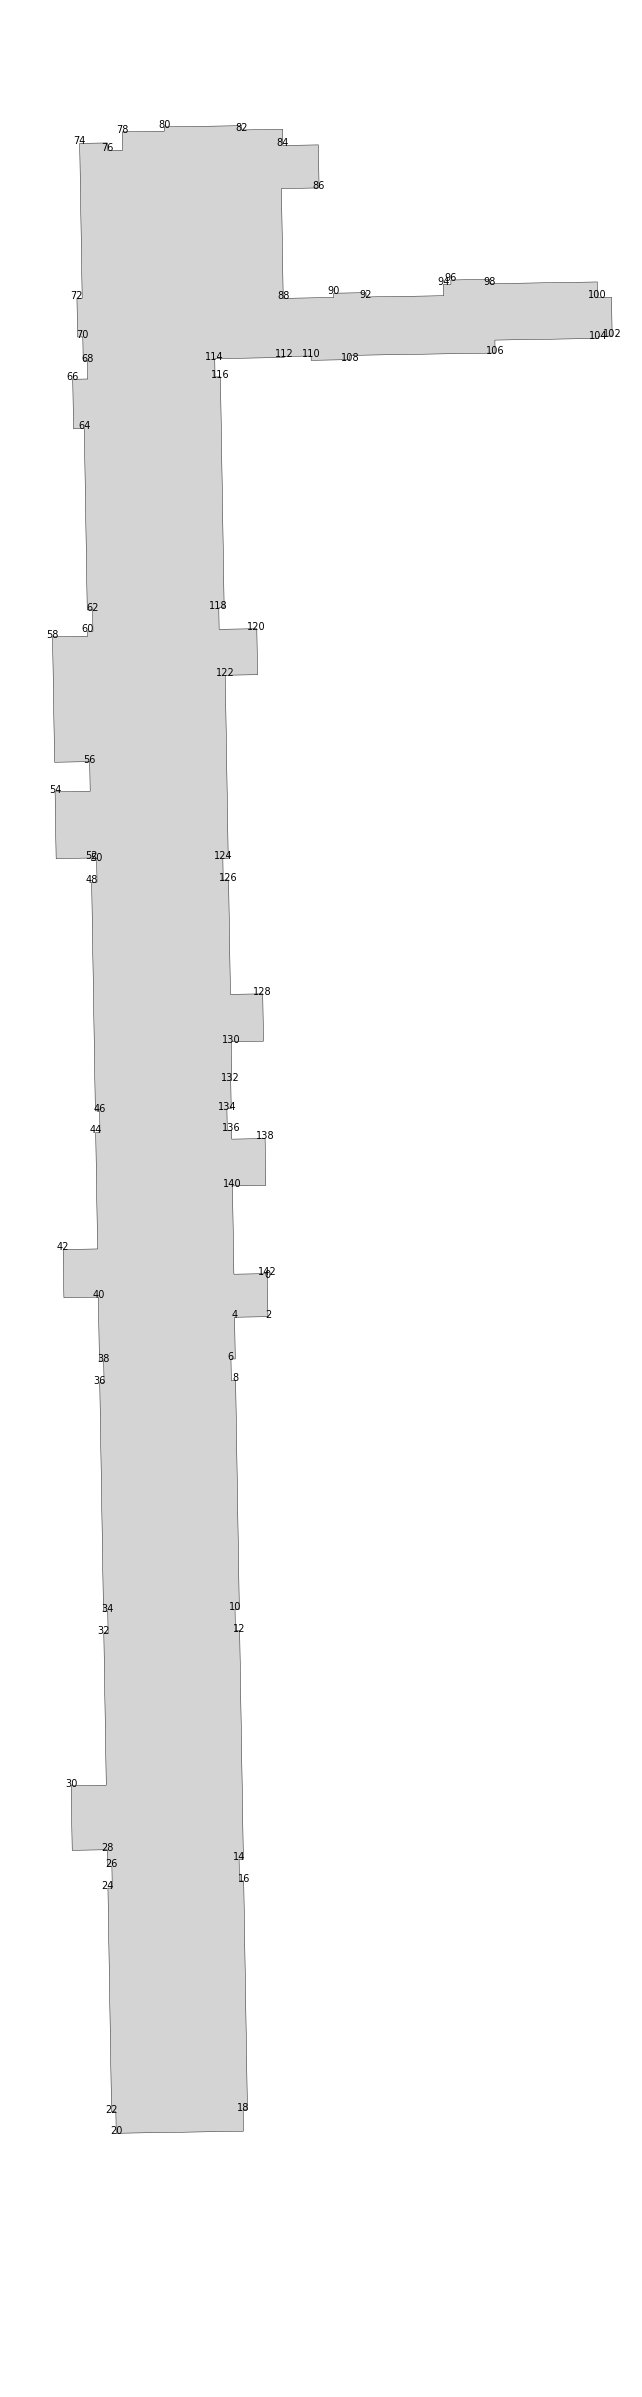

In [23]:
display_1_polygon(nr, 184)

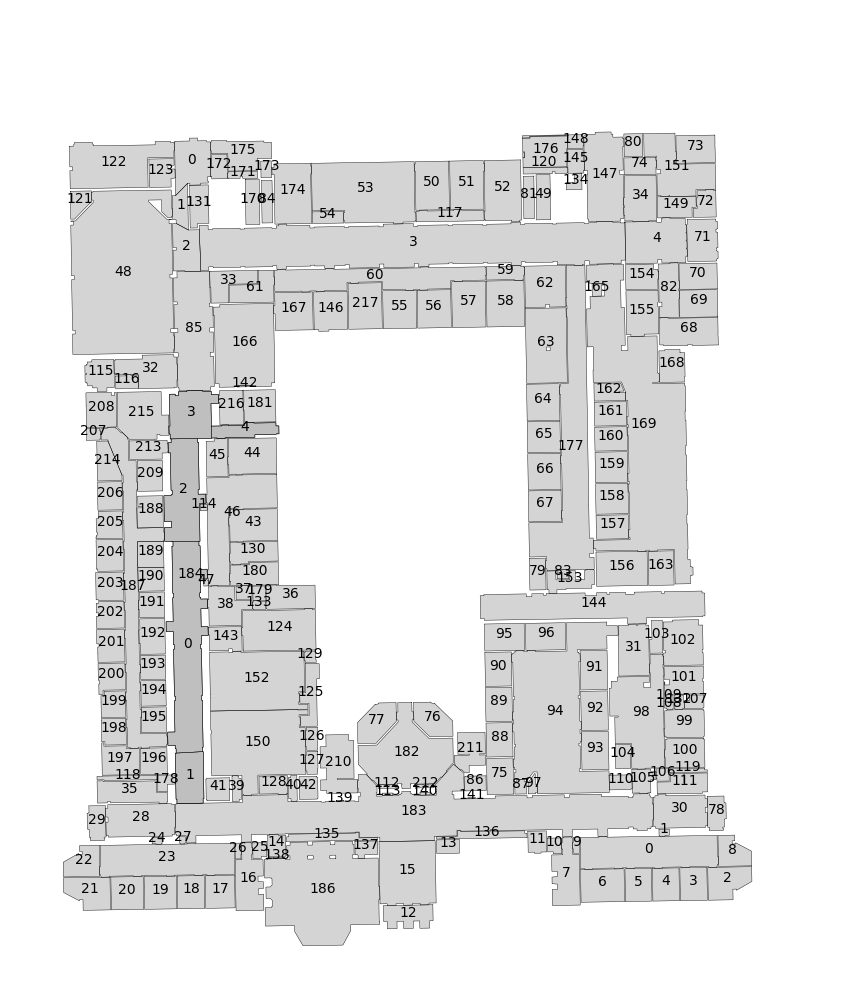

In [24]:
cut_points = [(88,112), 
              (68,114), 
              (50,124), 
              (25,15)]

nr2 = cut_polygon_with_line(nr, 184, cut_points)
show_rooms(nr2)

Two issues:
* original polygons seems to be still there.
* index is not unique.